In [1]:
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import tqdm
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
import joblib
from sklearn.metrics import mean_squared_error


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
#for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/feature-engineering-wids2022/feature_engineering.pkl
/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


## Reading Data

In [2]:
train = pd.read_csv('../input/widsdatathon2022/train.csv')
#train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../input/widsdatathon2022/test.csv')
#test = pd.read_csv('../data/test.csv')

#we will suppose that two  if two buildings have the same values for these features ; they are the sane building
# in other words groupby_cols = (building_id)
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
train['source'] = 'train'
test['source']  = 'test'
df = pd.concat([train,test], 0, ignore_index=True)
df=df.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


In [3]:
df.index

RangeIndex(start=0, stop=85462, step=1)

### Missing values imputation

### Category encoding
As we donwe will use **knn imputing**

In [4]:

# cats
df.loc[:,df.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'source'], dtype='object')

In [5]:

facility_type_qcut = pd.qcut(df['facility_type'].value_counts(), q=4, labels=[f'facility_type_qcut_{i}' for i in range(4)])
map_dict = dict(facility_type_qcut)
for i in map_dict:
    if map_dict[i] == 'facility_type_qcut_3':
        map_dict[i] = i
df['facility_type'] = df['facility_type'].map(map_dict)

In [6]:
cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df[col], dummy_na=False)
    for ohe_col in dummies:
        df[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [7]:
# Function to calculate missing values by column# Funct 
# from https://www.kaggle.com/parulpandey/starter-code-with-baseline
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values for training data
missing_values_train = missing_values_table(train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Your selected dataframe has 65 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [8]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df[['State_Factor', 'building_class', 'facility_type', 'source', target]]
    df = df.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

    joblib.dump(imputer, '../models/knn_imputer.pkl')

    for col in tmp.columns:
        df[col]=tmp[col]
    for col in df1.columns:
        df[col] = df1[col]

### Target Encoding

In [9]:

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df[f'te_{col}'] = encoder.fit_transform(df[col], df[target])

## Weather based features

we will extract new weather statistics from the building location weather features 

In [10]:
# extract new weather statistics from the building location weather features
temp = [col for col in df.columns if 'temp' in col]

df['min_temp'] = df[temp].min(axis=1)
df['max_temp'] = df[temp].max(axis=1)
df['avg_temp'] = df[temp].mean(axis=1)
df['std_temp'] = df[temp].std(axis=1)
df['skew_temp'] = df[temp].skew(axis=1)

# by seasons
temp = pd.Series([col for col in df.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df['min_winter_temp'] = df[winter_temp].min(axis=1)
df['max_winter_temp'] = df[winter_temp].max(axis=1)
df['avg_winter_temp'] = df[winter_temp].mean(axis=1)
df['std_winter_temp'] = df[winter_temp].std(axis=1)
df['skew_winter_temp'] = df[winter_temp].skew(axis=1)
### spring
df['min_spring_temp'] = df[spring_temp].min(axis=1)
df['max_spring_temp'] = df[spring_temp].max(axis=1)
df['avg_spring_temp'] = df[spring_temp].mean(axis=1)
df['std_spring_temp'] = df[spring_temp].std(axis=1)
df['skew_spring_temp'] = df[spring_temp].skew(axis=1)
### summer
df['min_summer_temp'] = df[summer_temp].min(axis=1)
df['max_summer_temp'] = df[summer_temp].max(axis=1)
df['avg_summer_temp'] = df[summer_temp].mean(axis=1)
df['std_summer_temp'] = df[summer_temp].max(axis=1)
df['skew_summer_temp'] = df[summer_temp].max(axis=1)
## autumn
df['min_autumn_temp'] = df[autumn_temp].min(axis=1)
df['max_autumn_temp'] = df[autumn_temp].max(axis=1)
df['avg_autumn_temp'] = df[autumn_temp].mean(axis=1)
df['std_autumn_temp'] = df[autumn_temp].std(axis=1)
df['skew_autumn_temp'] = df[autumn_temp].skew(axis=1)

In [11]:
df['month_cooling_degree_days'] = df['cooling_degree_days']/12
df['month_heating_degree_days'] = df['heating_degree_days']/12

### Buildig based feature:

In [12]:
# total area
df['building_area'] = df['floor_area'] * df['ELEVATION']
# rating energy by floor
df['floor_energy_star_rating'] = df['energy_star_rating']/df['ELEVATION']


## Lag based features:
we will compute lagged features values up to three years for the following features:
* site_eui
* energy_star
* ELEVATION
* temp features

In [13]:

temp_features = [col for col in df.columns if 'temp' in col]

for lag_year in [1,2,3] :
    # building mesh
    df[f'site_eui_lag{lag_year}'] = df.groupby(groupby_cols)['site_eui'].shift(lag_year) # because it is sorted by year factor
    df[f'energy_star_rating_lag{lag_year}'] = df.groupby(groupby_cols)['energy_star_rating'].shift(lag_year)
    df[f'ELEVATION_lag{lag_year}'] = df.groupby(groupby_cols)['ELEVATION'].shift(lag_year)
    for temp in temp_features:
        df[f'{temp}_lag{lag_year}'] = df.groupby(groupby_cols)[temp].shift(lag_year)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

### Rolling based features :
average of feature value through the last 3 years

In [14]:
# rolling average
for i in range(1, 3) :
    # building mesh
    df[f'site_eui_roll_avg{i}'] = df.groupby(groupby_cols)['site_eui'].shift(i).rolling(3).mean()
    df[f'energy_star_rating_roll_avg{i}'] = df.groupby(groupby_cols)['energy_star_rating'].shift(i).rolling(3).mean()
    df[f'ELEVATION_roll_avg{i}'] = df.groupby(groupby_cols)['ELEVATION'].shift(i).rolling(3).mean()
    for temp in temp_features:
        df[f'{temp}_roll_avg{i}'] = df.groupby(groupby_cols)[temp].shift(i).rolling(3).mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

## Delta based features
Delta current value vs previous year:


In [15]:
for var in ['site_eui', 'energy_star_rating', 'ELEVATION'] + temp_features:
    df[f'delta_{var}_2_1']  = np.where(df[f'{var}_lag2'].notnull() & df[f'{var}_lag1'].notnull() ,
                                    abs(df[f'{var}_lag1']-df[f'{var}_lag2'] ) / df[f'{var}_lag2'],
                                    np.nan )
    # df[f'{var}_lag1'] = df[f'{var}_lag2'] + df[f'{var}_lag2'] * df[f'delta_{var}_2_1']
    # we consider df[f'{var}'] = df[f'{var}_lag1'] + df[f'{var}_lag1'] * df[f'delta_{var}_2_1']
    df[f'{var}_from_delta2_1']  = np.where(df[f'{var}_lag1'].notnull() ,
                                    df[f'{var}_lag1'] + df[f'{var}_lag1'] * df[f'delta_{var}_2_1'],
                                    np.nan )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [16]:
df['site_eui_coeff'] = (df['energy_star_rating_lag2']* df[f'site_eui_lag1'] - df[f'site_eui_lag2']*df['energy_star_rating_lag2'])/(df['site_eui_lag1'] - df['site_eui_lag2'])
df['site_eui_from_site_eui_coeff'] = df['site_eui_coeff']*df[f'site_eui_lag1']



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [17]:
# groupby function
for col in ['State_Factor', 'building_class', 'facility_type', 'energy_star_rating']:
    print(col)
    cols=[col, 'Year_Factor']
    tmp = df.sort_values(cols).groupby(cols).agg({
                "site_eui": ['mean', 'median','max','min','sum']  ,
    #            "year_built": ['mean', 'median','max','min'] ,
                "energy_star_rating" : ['min','max','mean', 'median'] ,
                "id" : "count"
                          }).shift(1).reset_index()
    for idx in tmp.columns:
        if idx[1] != '':
            print(f'{idx[1]}_{idx[0]}_by_{col}_lag1')
            cols.append(f'{idx[1]}_{idx[0]}_by_{col}_lag1')
    tmp.columns = cols
    df = df.merge(tmp, on=[col, 'Year_Factor'], how='left')
    print(df.shape)

State_Factor
mean_site_eui_by_State_Factor_lag1
median_site_eui_by_State_Factor_lag1
max_site_eui_by_State_Factor_lag1
min_site_eui_by_State_Factor_lag1
sum_site_eui_by_State_Factor_lag1
min_energy_star_rating_by_State_Factor_lag1
max_energy_star_rating_by_State_Factor_lag1
mean_energy_star_rating_by_State_Factor_lag1
median_energy_star_rating_by_State_Factor_lag1
count_id_by_State_Factor_lag1
(85462, 583)
building_class
mean_site_eui_by_building_class_lag1
median_site_eui_by_building_class_lag1
max_site_eui_by_building_class_lag1
min_site_eui_by_building_class_lag1
sum_site_eui_by_building_class_lag1
min_energy_star_rating_by_building_class_lag1
max_energy_star_rating_by_building_class_lag1
mean_energy_star_rating_by_building_class_lag1
median_energy_star_rating_by_building_class_lag1
count_id_by_building_class_lag1
(85462, 593)
facility_type
mean_site_eui_by_facility_type_lag1
median_site_eui_by_facility_type_lag1
max_site_eui_by_facility_type_lag1
min_site_eui_by_facility_type_lag1


Text(0.5, 0, 'Transformed site_eui')

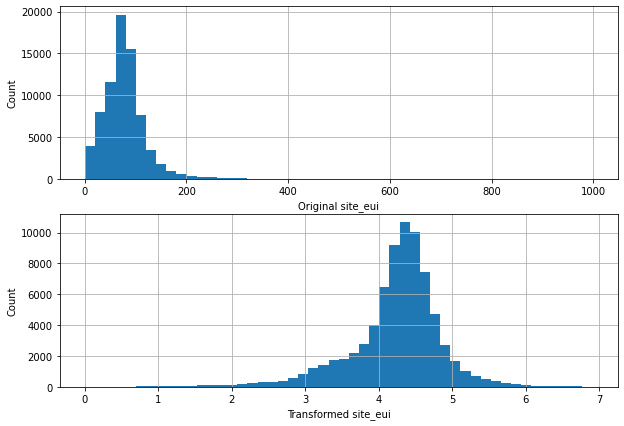

In [18]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target)



In [19]:
train.dtypes != 'object'

Year_Factor        True
State_Factor      False
building_class    False
facility_type     False
floor_area         True
                  ...  
max_wind_speed     True
days_with_fog      True
site_eui           True
id                 True
source            False
Length: 65, dtype: bool

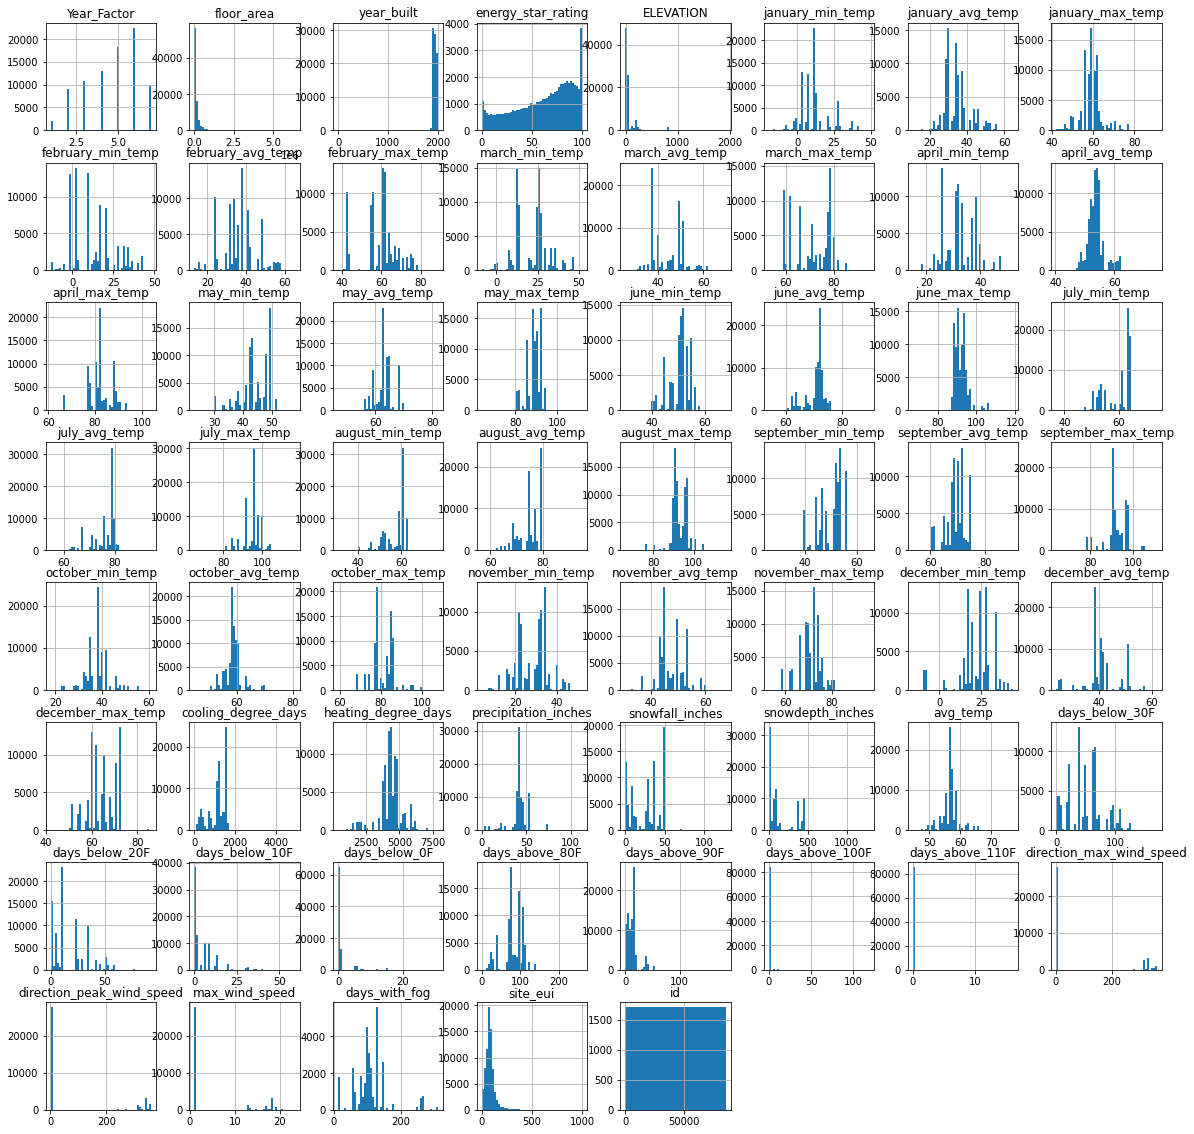

In [20]:
nums = train.loc[:, train.dtypes != 'object'].columns
df[nums].hist(bins=50, figsize=(20,20))
plt.show()

In [21]:
df[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.706906
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

Binarize very skewed variables

In [22]:
skewed = [
    'days_above_110F', 'days_above_100F'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    df[var] = np.where(df[var]==0, 0, 1)

In [23]:
# save data
saved = True
if saved:
    !pip3 install pickle5
    import pickle5 as pickle
    data_path = '../input/feature-engineering-wids2022/feature_engineering.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df.to_pickle('../feature_engineering.pkl')

     |████████████████████████████████| 256 kB 3.1 MB/s            


In [24]:
# later

df.shape

(85462, 613)

In [25]:
df.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,sum_site_eui_by_energy_star_rating_lag1,min_energy_star_rating_by_energy_star_rating_lag1,max_energy_star_rating_by_energy_star_rating_lag1,mean_energy_star_rating_by_energy_star_rating_lag1,median_energy_star_rating_by_energy_star_rating_lag1,count_id_by_energy_star_rating_lag1,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,...,854.963254,38.428571,38.428571,38.428571,38.428571,9.0,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,...,1068.909483,43.571429,43.571429,43.571429,43.571429,13.0,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,...,373.562641,37.571429,37.571429,37.571429,37.571429,6.0,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,...,1815.692535,60.285714,60.285714,60.285714,60.285714,17.0,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,...,1877.696982,45.571429,45.571429,45.571429,45.571429,21.0,25.250000,259.000000,97870.5,5.007849


## Catboost

In [26]:
train = df[df['source']=='train']
test = df[df['source']=='train']

cats = ['State_Factor', 'facility_type', 'building_class']
    


In [27]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
test_ids = test['id']
train_ids = train['id']
target = train['site_eui']
train = train.drop(['id', 'source', 'site_eui'], axis=1)#['id', 'source', 'Year_Factor', target]+cats
test = test.drop(['id', 'source', 'site_eui'], axis=1)

# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [28]:
for i in cats_discrete_idx:
    print(train.columns[i])

days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [29]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

In [30]:
NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)
# we. can also use 

for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    ## config from https://www.kaggle.com/nicapotato/simple-catboost
    model = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    model.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = model.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += model.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))

0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0132553	test: 55.0654005	best: 55.0654005 (0)	total: 1.31s	remaining: 10m 52s
75:	learn: 40.6753874	test: 37.3892947	best: 37.3892947 (75)	total: 1m 34s	remaining: 8m 46s
150:	learn: 37.3421982	test: 34.9011462	best: 34.9011462 (150)	total: 3m 7s	remaining: 7m 13s
225:	learn: 36.0305934	test: 34.3268848	best: 34.3268848 (225)	total: 4m 41s	remaining: 5m 40s
300:	learn: 35.2205195	test: 34.0774834	best: 34.0774834 (300)	total: 6m 15s	remaining: 4m 8s
375:	learn: 34.5463736	test: 33.9247798	best: 33.9238079 (373)	total: 7m 49s	remaining: 2m 34s
450:	learn: 34.0340825	test: 33.8331173	best: 33.8325336 (448)	total: 9m 21s	remaining: 1m 1s
499:	learn: 33.7493584	test: 33.8071608	best: 33.8056877 (493)	total: 10m 21s	remaining: 0us

bestTest = 33.80568769
bestIteration = 493

Shrink model to first 494 iterations.


1it [10:23, 623.59s/it]

out-of-folds prdiction ==== fold_0 RMSE 5.814265882127027


0:	learn: 57.6139957	test: 58.6434624	best: 58.6434624 (0)	total: 1.3s	remaining: 10m 49s
75:	learn: 40.3929489	test: 41.8770796	best: 41.8770796 (75)	total: 1m 37s	remaining: 9m 3s
150:	learn: 37.0293625	test: 39.3562322	best: 39.3562322 (150)	total: 3m 11s	remaining: 7m 23s
225:	learn: 35.7077431	test: 38.6899686	best: 38.6899686 (225)	total: 4m 45s	remaining: 5m 46s
300:	learn: 34.8893668	test: 38.4268482	best: 38.4268482 (300)	total: 6m 19s	remaining: 4m 10s
375:	learn: 34.2740162	test: 38.2450599	best: 38.2450599 (375)	total: 7m 51s	remaining: 2m 35s
450:	learn: 33.7306381	test: 38.1553219	best: 38.1546456 (449)	total: 9m 23s	remaining: 1m 1s
499:	learn: 33.4311191	test: 38.0966137	best: 38.0966137 (499)	total: 10m 23s	remaining: 0us

bestTest = 38.09661365
bestIteration = 499



2it [20:48, 624.40s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.172245420939534


0:	learn: 57.3437010	test: 60.9402276	best: 60.9402276 (0)	total: 1.28s	remaining: 10m 40s
75:	learn: 40.1493414	test: 44.0045660	best: 44.0045660 (75)	total: 1m 36s	remaining: 8m 59s
150:	learn: 36.9587540	test: 41.1780935	best: 41.1780935 (150)	total: 3m 10s	remaining: 7m 20s
225:	learn: 35.7437638	test: 40.4319670	best: 40.4319670 (225)	total: 4m 43s	remaining: 5m 43s
300:	learn: 35.0134671	test: 40.0584263	best: 40.0584263 (300)	total: 6m 15s	remaining: 4m 8s
375:	learn: 34.3721724	test: 39.8118675	best: 39.8118675 (375)	total: 7m 49s	remaining: 2m 34s
450:	learn: 33.8800323	test: 39.6569044	best: 39.6554116 (448)	total: 9m 22s	remaining: 1m 1s
499:	learn: 33.4682547	test: 39.5403956	best: 39.5403956 (499)	total: 10m 23s	remaining: 0us

bestTest = 39.54039563
bestIteration = 499



3it [31:14, 624.93s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.288115414872863


0:	learn: 58.1679530	test: 53.3657281	best: 53.3657281 (0)	total: 1.24s	remaining: 10m 17s
75:	learn: 40.6621582	test: 37.1083923	best: 37.1083923 (75)	total: 1m 36s	remaining: 8m 55s
150:	learn: 37.3472689	test: 35.0071890	best: 35.0071890 (150)	total: 3m 10s	remaining: 7m 21s
225:	learn: 36.0668675	test: 34.5059691	best: 34.5059691 (225)	total: 4m 44s	remaining: 5m 45s
300:	learn: 35.3088144	test: 34.2952183	best: 34.2952183 (300)	total: 6m 19s	remaining: 4m 10s
375:	learn: 34.5986741	test: 34.1155705	best: 34.1155705 (375)	total: 7m 52s	remaining: 2m 35s
450:	learn: 34.0095339	test: 34.0017370	best: 33.9986433 (447)	total: 9m 23s	remaining: 1m 1s
499:	learn: 33.6239843	test: 33.9449719	best: 33.9449719 (499)	total: 10m 22s	remaining: 0us

bestTest = 33.94497188
bestIteration = 499



4it [41:38, 624.80s/it]

out-of-folds prdiction ==== fold_3 RMSE 5.8262313652892095


0:	learn: 57.3118511	test: 61.2960622	best: 61.2960622 (0)	total: 1.24s	remaining: 10m 18s
75:	learn: 39.8167019	test: 45.9254963	best: 45.9254963 (75)	total: 1m 35s	remaining: 8m 55s
150:	learn: 36.4135644	test: 43.8458843	best: 43.8458843 (150)	total: 3m 10s	remaining: 7m 20s
225:	learn: 35.0574173	test: 43.4341486	best: 43.4341486 (225)	total: 4m 42s	remaining: 5m 43s
300:	learn: 34.3897826	test: 43.2716198	best: 43.2716198 (300)	total: 6m 9s	remaining: 4m 4s
375:	learn: 33.8790846	test: 43.1863293	best: 43.1863293 (375)	total: 7m 38s	remaining: 2m 31s
450:	learn: 33.2648978	test: 43.0697656	best: 43.0695806 (449)	total: 9m 8s	remaining: 59.6s
499:	learn: 32.8957303	test: 43.0239224	best: 43.0236031 (497)	total: 10m 9s	remaining: 0us

bestTest = 43.02360313
bestIteration = 497

Shrink model to first 498 iterations.


5it [51:49, 619.71s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.5592379979087925


0:	learn: 57.9711430	test: 55.4362299	best: 55.4362299 (0)	total: 1.28s	remaining: 10m 40s
75:	learn: 40.6799651	test: 38.2147990	best: 38.2147990 (75)	total: 1m 35s	remaining: 8m 53s
150:	learn: 37.4499155	test: 35.6897642	best: 35.6897642 (150)	total: 3m 9s	remaining: 7m 18s
225:	learn: 36.1437378	test: 35.0843912	best: 35.0843912 (225)	total: 4m 43s	remaining: 5m 43s
300:	learn: 35.3333072	test: 34.7862659	best: 34.7862659 (300)	total: 6m 16s	remaining: 4m 9s
375:	learn: 34.7322701	test: 34.6397586	best: 34.6397586 (375)	total: 7m 49s	remaining: 2m 34s
450:	learn: 34.2363292	test: 34.5284092	best: 34.5284092 (450)	total: 9m 23s	remaining: 1m 1s
499:	learn: 33.9094862	test: 34.4767477	best: 34.4759562 (493)	total: 10m 23s	remaining: 0us

bestTest = 34.47595619
bestIteration = 493

Shrink model to first 494 iterations.


6it [1:02:14, 621.60s/it]

out-of-folds prdiction ==== fold_5 RMSE 5.871622968509301


0:	learn: 57.5083236	test: 59.6652482	best: 59.6652482 (0)	total: 1.25s	remaining: 10m 26s
75:	learn: 40.0845426	test: 43.8321944	best: 43.8321944 (75)	total: 1m 35s	remaining: 8m 54s
150:	learn: 36.6767493	test: 41.5195940	best: 41.5195940 (150)	total: 3m 10s	remaining: 7m 20s
225:	learn: 35.3243814	test: 40.9776579	best: 40.9776579 (225)	total: 4m 44s	remaining: 5m 44s
300:	learn: 34.5771621	test: 40.7389408	best: 40.7379895 (298)	total: 6m 17s	remaining: 4m 9s
375:	learn: 33.9927242	test: 40.6257327	best: 40.6250311 (373)	total: 7m 51s	remaining: 2m 35s
450:	learn: 33.4403884	test: 40.5601582	best: 40.5575423 (440)	total: 9m 25s	remaining: 1m 1s
499:	learn: 33.1738160	test: 40.5309409	best: 40.5308966 (498)	total: 10m 26s	remaining: 0us

bestTest = 40.53089658
bestIteration = 498

Shrink model to first 499 iterations.


7it [1:12:43, 623.86s/it]

out-of-folds prdiction ==== fold_6 RMSE 6.366388036804879


0:	learn: 58.4887210	test: 50.3647736	best: 50.3647736 (0)	total: 1.32s	remaining: 10m 58s
75:	learn: 40.9837429	test: 33.6650115	best: 33.6650115 (75)	total: 1m 34s	remaining: 8m 49s
150:	learn: 37.6384418	test: 31.9240757	best: 31.9240757 (150)	total: 3m 9s	remaining: 7m 17s
225:	learn: 36.3076578	test: 31.7149836	best: 31.7117979 (213)	total: 4m 43s	remaining: 5m 43s
300:	learn: 35.4364655	test: 31.6288054	best: 31.6288054 (300)	total: 6m 16s	remaining: 4m 9s
375:	learn: 34.8446588	test: 31.5611895	best: 31.5611895 (375)	total: 7m 49s	remaining: 2m 34s
450:	learn: 34.2861073	test: 31.5212527	best: 31.5212527 (450)	total: 9m 23s	remaining: 1m 1s
499:	learn: 33.9859227	test: 31.5136429	best: 31.5023340 (488)	total: 10m 22s	remaining: 0us

bestTest = 31.50233401
bestIteration = 488

Shrink model to first 489 iterations.


8it [1:23:07, 623.97s/it]

out-of-folds prdiction ==== fold_7 RMSE 5.612694006727581


0:	learn: 57.8531506	test: 56.6486533	best: 56.6486533 (0)	total: 1.25s	remaining: 10m 21s
75:	learn: 40.4234294	test: 40.2654555	best: 40.2654555 (75)	total: 1m 35s	remaining: 8m 51s
150:	learn: 36.9817339	test: 37.9466324	best: 37.9466324 (150)	total: 3m 9s	remaining: 7m 17s
225:	learn: 35.6445760	test: 37.3649068	best: 37.3649068 (225)	total: 4m 43s	remaining: 5m 43s
300:	learn: 34.7844571	test: 37.1018721	best: 37.1018721 (300)	total: 6m 16s	remaining: 4m 8s
375:	learn: 34.1250373	test: 36.9407223	best: 36.9407223 (375)	total: 7m 48s	remaining: 2m 34s
450:	learn: 33.4956932	test: 36.8147117	best: 36.8147090 (449)	total: 9m 18s	remaining: 1m
499:	learn: 33.1401817	test: 36.7578360	best: 36.7578360 (499)	total: 10m 17s	remaining: 0us

bestTest = 36.75783595
bestIteration = 499



9it [1:33:26, 622.60s/it]

out-of-folds prdiction ==== fold_8 RMSE 6.0628240689368935


0:	learn: 56.9349530	test: 64.5661225	best: 64.5661225 (0)	total: 1.35s	remaining: 11m 13s
75:	learn: 39.5449489	test: 48.6911957	best: 48.6911957 (75)	total: 1m 35s	remaining: 8m 52s
150:	learn: 36.2121178	test: 46.2669096	best: 46.2669096 (150)	total: 3m 9s	remaining: 7m 17s
225:	learn: 34.8763525	test: 45.6079581	best: 45.6079581 (225)	total: 4m 42s	remaining: 5m 42s
300:	learn: 33.9864828	test: 45.2483826	best: 45.2483826 (300)	total: 6m 15s	remaining: 4m 8s
375:	learn: 33.3771011	test: 45.0567843	best: 45.0567843 (375)	total: 7m 47s	remaining: 2m 34s
450:	learn: 32.8063833	test: 44.8890793	best: 44.8890793 (450)	total: 9m 20s	remaining: 1m
499:	learn: 32.4721559	test: 44.8170820	best: 44.8170461 (498)	total: 10m 20s	remaining: 0us

bestTest = 44.81704613
bestIteration = 498

Shrink model to first 499 iterations.


10it [1:43:49, 622.95s/it]

out-of-folds prdiction ==== fold_9 RMSE 6.694553468622229


## Save Data

In [31]:
# save results
np.save('train_oof.npy', train_oof)
np.save('test_preds.npy', test_preds)

In [32]:
sub = pd.DataFrame(columns=['id', 'site_eui'])
sub['id']  = test_ids
sub['site_eui'] = test_preds
sub.to_csv('submission_CB2.csv', index=False)